In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold, train_test_split,cross_val_score
from sklearn import metrics

//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
data = pd.read_csv('data.csv')
print data.shape
data.info()

(30697, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_n

## Feature Engineering

In [3]:
#at home or not
data['home?'] = data['matchup'].apply(lambda x: x.split('@')[0].strip()=='LAL')
data['home?'].describe()

count     30697
unique        2
top        True
freq      15741
Name: home?, dtype: object

In [4]:
#2PT or 3PT shot_type
data['shot_type?'] = data['shot_type']=='2PT Field Goal'
data['shot_type?'].describe()

count     30697
unique        2
top        True
freq      24271
Name: shot_type?, dtype: object

In [5]:
#playoff or not
data['playoffs?'] = data['playoffs']==1
data['playoffs?'].describe()

count     30697
unique        2
top       False
freq      26198
Name: playoffs?, dtype: object

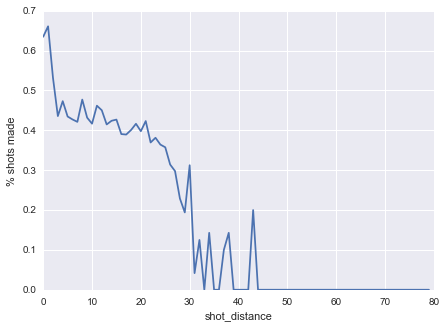

In [6]:
# use Kaggle's script to encode categorical features
# Shooting accuracy with shot distance
def get_acc(df, against):
    ct = pd.crosstab(df.shot_made_flag, df[against]).apply(lambda x:x/x.sum(), axis=0)
    x, y = ct.columns, ct.values[1, :]
    plt.figure(figsize=(7, 5))
    plt.plot(x, y)
    plt.xlabel(against)
    plt.ylabel('% shots made')
    #plt.savefig(against + '_vs_accuracy.png')
    
get_acc(data, 'shot_distance')

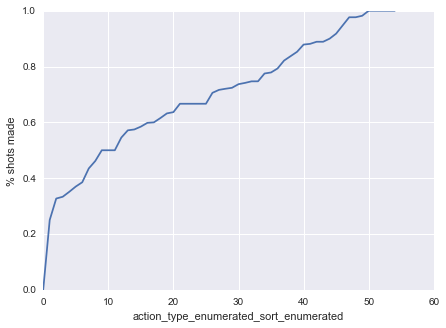

In [7]:
#use kaggle script to sort_encode 'action_type' 

action_map = {action: i for i, action in enumerate(data.action_type.unique())}
data['action_type_enumerated'] = data.action_type.map(action_map)

def sort_encode(df, field):
    ct = pd.crosstab(df.shot_made_flag, df[field]).apply(lambda x:x/x.sum(), axis=0)
    temp = list(zip(ct.values[1, :], ct.columns))
    temp.sort()
    new_map = {}
    for index, (acc, old_number) in enumerate(temp):
        new_map[old_number] = index
    new_field = field + '_sort_enumerated'
    df[new_field] = df[field].map(new_map)
    get_acc(df, new_field)

sort_encode(data, 'action_type_enumerated')

In [8]:
pd.crosstab(data.shot_made_flag, data['action_type_enumerated_sort_enumerated']).apply(lambda x:x/x.sum(), axis=0)

action_type_enumerated_sort_enumerated,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0
shot_made_flag,,,,,,,,,,,,,,,,,,,,,
0.0,1.0,0.75,0.673087,0.666667,0.649007,0.630137,0.61467,0.565217,0.538462,0.5,...,0.081967,0.052632,0.023346,0.023256,0.017964,0.0,0.0,0.0,0.0,0.0
1.0,0.0,0.25,0.326913,0.333333,0.350993,0.369863,0.38533,0.434783,0.461538,0.5,...,0.918033,0.947368,0.976654,0.976744,0.982036,1.0,1.0,1.0,1.0,1.0


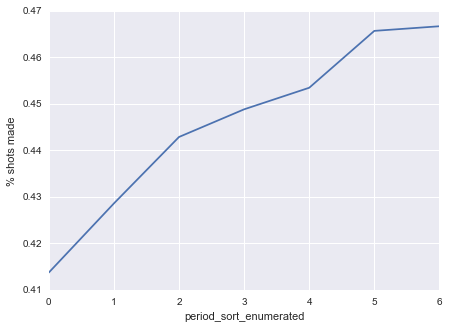

In [9]:
sort_encode(data,'period')

In [10]:
pd.crosstab(data.shot_made_flag, data['period_sort_enumerated']).apply(lambda x:x/x.sum(), axis=0)

period_sort_enumerated,0,1,2,3,4,5,6
shot_made_flag,,,,,,,
0.0,0.586298,0.571429,0.557143,0.551198,0.546558,0.534328,0.533333
1.0,0.413702,0.428571,0.442857,0.448802,0.453442,0.465672,0.466667


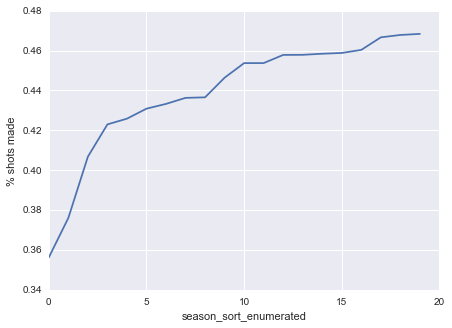

In [11]:
sort_encode(data,'season')

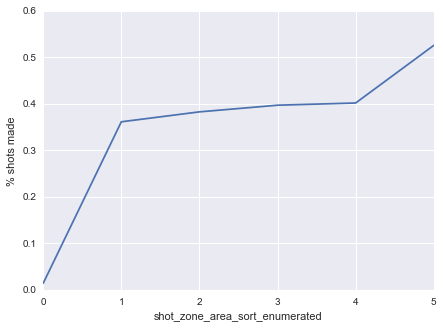

In [13]:
sort_encode(data,'shot_zone_area')

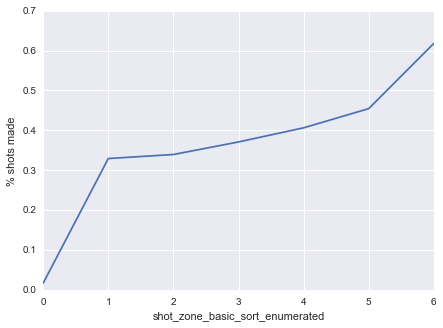

In [14]:
sort_encode(data,'shot_zone_basic')

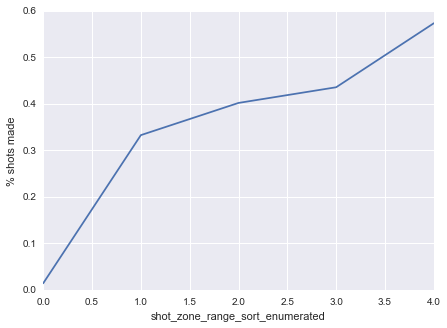

In [15]:
sort_encode(data,'shot_zone_range')

# Modeling with randomforest

In [16]:
data.columns

Index([u'action_type', u'combined_shot_type', u'game_event_id', u'game_id',
       u'lat', u'loc_x', u'loc_y', u'lon', u'minutes_remaining', u'period',
       u'playoffs', u'season', u'seconds_remaining', u'shot_distance',
       u'shot_made_flag', u'shot_type', u'shot_zone_area', u'shot_zone_basic',
       u'shot_zone_range', u'team_id', u'team_name', u'game_date', u'matchup',
       u'opponent', u'shot_id', u'home?', u'shot_type?', u'playoffs?',
       u'action_type_enumerated', u'action_type_enumerated_sort_enumerated',
       u'period_sort_enumerated', u'season_sort_enumerated',
       u'shot_zone_area_sort_enumerated', u'shot_zone_basic_sort_enumerated',
       u'shot_zone_range_sort_enumerated'],
      dtype='object')

In [18]:
cols_use=['action_type_enumerated_sort_enumerated','period_sort_enumerated','season_sort_enumerated',\
         'playoffs?','home?', 'shot_type?', 'shot_distance','shot_zone_area_sort_enumerated',\
         'shot_zone_basic_sort_enumerated','shot_zone_range_sort_enumerated','shot_made_flag']
cols_maybe =['loc_x', 'loc_y','combined_shot_type']

In [23]:
#simple test function

def test_it(data): #input data with cols_use and 'shot_made_flag'
    clf = RandomForestClassifier(n_estimators=100,n_jobs=-1) #specify tree and depth
    return cross_val_score(clf, data.drop('shot_made_flag', 1), data.shot_made_flag,
                           scoring='accuracy', cv=10)


In [24]:
df = data[cols_use]
df = df.dropna()
test_it(df).mean()

0.61061516833310725

In [25]:
#remove period and season
cols_use2=['action_type_enumerated_sort_enumerated',
         'playoffs?','home?', 'shot_type?', 'shot_distance','shot_zone_area_sort_enumerated',\
         'shot_zone_basic_sort_enumerated','shot_zone_range_sort_enumerated','shot_made_flag']
df = data[cols_use2]
df = df.dropna()
test_it(df).mean()

0.66345919863823188

In [26]:
#remove three more features, 'shot_zone_area/basic/range'
cols_use3=['action_type_enumerated_sort_enumerated',
         'playoffs?','home?', 'shot_type?', 'shot_distance','shot_made_flag']
df = data[cols_use3]
df = df.dropna()
test_it(df).mean()

0.67015220005517384

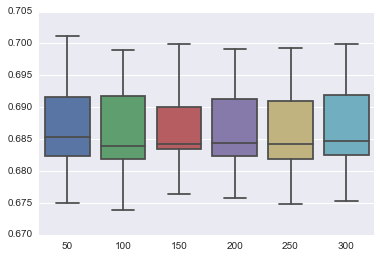

In [31]:
#test number of trees, using 'roc_auc' as metrics
#not very different, choose 50 trees

estimators, scores = list(range(50,350,50)), []
for i in estimators:
    clf = RandomForestClassifier(n_jobs=-1, n_estimators=i)
    x = cross_val_score(clf, df.drop('shot_made_flag', 1), df.shot_made_flag,
                              scoring='roc_auc', cv=5)
    scores.append(x)
x = [i for i in estimators for j in range(5)]
sns.boxplot(x, np.array(scores).flatten())

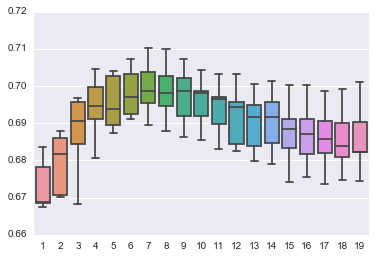

In [32]:
#test depth of trees
#choose max_depth=7
depth, scores = list(range(1, 20, 1)), []
for i in depth:
    clf = RandomForestClassifier(n_jobs=-1, n_estimators=50, max_depth=i)
    x = cross_val_score(clf, df.drop('shot_made_flag', 1), df.shot_made_flag,
                              scoring='roc_auc', cv=5)
    scores.append(x)
x = [i for i in depth for j in range(5)]
sns.boxplot(x, np.array(scores).flatten())

## Make submissions

In [33]:
cols_use3=['action_type_enumerated_sort_enumerated',
         'playoffs?','home?', 'shot_type?', 'shot_distance','shot_made_flag']
cols_use4 = cols_use3 + ['shot_id'] #need 'shot_id' for test data submission
len(cols_use3),len(cols_use4)

(6, 7)

In [34]:
train = data.loc[data.shot_made_flag.notnull(),cols_use3]
test = data.loc[data.shot_made_flag.isnull(),cols_use4]
train.shape,test.shape

((25697, 6), (5000, 7))

In [35]:
#two null in 'action_type_enumerated_sort_enumerated'
test.ix[test['action_type_enumerated_sort_enumerated'].isnull(),:]

,action_type_enumerated_sort_enumerated,playoffs?,home?,shot_type?,shot_distance,shot_made_flag,shot_id
22577,NaN,False,True,True,14,NaN,22578
22623,NaN,False,False,True,2,NaN,22624


In [36]:
#fill null for test
mode = test.action_type_enumerated_sort_enumerated.mode()[0]
test.action_type_enumerated_sort_enumerated.fillna(mode, inplace=True)

In [37]:
clf = RandomForestClassifier(n_estimators=100,n_jobs=-1,max_depth=7)
clf.fit(train.drop('shot_made_flag', 1), train.shot_made_flag)
predictions = clf.predict_proba(test.drop(['shot_made_flag','shot_id'],1))

In [38]:
predictions[:10]

array([[ 0.64823046,  0.35176954],
       [ 0.72613798,  0.27386202],
       [ 0.24507289,  0.75492711],
       [ 0.24507289,  0.75492711],
       [ 0.65166973,  0.34833027],
       [ 0.64165619,  0.35834381],
       [ 0.5483575 ,  0.4516425 ],
       [ 0.5483575 ,  0.4516425 ],
       [ 0.27542893,  0.72457107],
       [ 0.65227523,  0.34772477]])

In [112]:
submission = pd.DataFrame({'shot_id': test.shot_id,
                           'shot_made_flag': predictions[:, 1]})
submission[['shot_id', 'shot_made_flag']].to_csv('submission.csv', index=False)